<a href="https://colab.research.google.com/github/alaguilarunal/final_proyect_GHMM/blob/main/GHMM_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.6 MB/s eta 0:00:00


In [126]:
import pandas as pd
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact, IntSlider
import warnings
#Paquetes para modelos comparativo basado en LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

#Carga de dataset

In [ ]:
df = pd.read_csv('BTC-USD.csv')
data = df[['Close', 'Open', 'High', 'Low']]
data = data.to_numpy()
print("Longitud del dataset",len(data))
df.head()

Longitud del dataset 3104


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
1,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
3,2015-01-06,274.610992,287.553009,272.696014,286.188995,286.188995,23245700
4,2015-01-07,286.076996,298.753998,283.079010,294.337006,294.337006,24866800


#Calculo del BIC

In [ ]:
def mod_BIC(num_params: int, model_score: float, dataset_size: int) -> float:
    # Bayesian information criterion modification
    # In this case higher is better
    return model_score - num_params * np.log(dataset_size)

def comp_num_params(states: int) -> int:
    # From
    # 2 parameters per gaussian distribution
    # states - 1 parameters in the initial distribution (last parameter is determined by the others)
    # states * (states - 1) parameters in the transition matrix (last parameter per state is determined by the others)
    # N^2 - N + 2N + N - 1 = N^2 + 2N - 1
    return states ** 2 + 2 * states - 1

#Rutina para entranamiento de modelo GHMM y calculo del BIC

In [127]:
def evaluate_configuration(configuration):
  optimal_states = 0
  #print(">Configuracion: ",configuration)
  if optimal_states == 0:
      possible_states = [*range(5, 23)]
      data_fit = data[:configuration['size_data'], :]
      #BICS = []
      models_by_states=[]
      for states in possible_states:
          model = hmm.GaussianHMM(n_components=states, tol=configuration['tol'], n_iter=configuration['iter'])
          random_transmat = np.random.rand(states, states)
          random_transmat /= random_transmat.sum(axis=1, keepdims=True)  # Normaliza las filas

          # Asignar la matriz de transición aleatoria al modelo
          model.transmat_ = random_transmat
          with warnings.catch_warnings(record=True) as w:
              warnings.simplefilter("always")
              model.fit(data_fit)
              try:
                  score = model.score(data)
              except ValueError:
                  score = - np.inf
              has_warning = any("Some rows of transmat_ have zero sum" in str(warn.message) for warn in w)
              if has_warning:
                model_BIC = -np.inf
                configuration["BICS_per_possible_states"].append(model_BIC)
                continue
              model_BIC = mod_BIC(comp_num_params(states), score, data.shape[0])
          #BICS.append(model_BIC)
          configuration["BICS_per_possible_states"].append(model_BIC)
          models_by_states.append({
              "BIC":model_BIC,
              "model":model
          })
      #optimal_states = possible_states[np.argmax(BICS)]
      configuration["optimal_states"]=possible_states[np.argmax(configuration["BICS_per_possible_states"])]
      configuration["model"]=max(models_by_states, key=lambda x: x["BIC"])
      print(">Configuracion Elegida", configuration)

#Configuración de Hiper parámetros: Se definen las configuraciones de hiper parámetros para la exploracion de modelos GHMM

In [128]:
hiper_params_training=[
    {
        "size_data":1000,
        "tol":0.001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1000,
        "tol":0.0001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1000,
        "tol":0.0001,
        "iter":100000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1000,
        "tol":0.0001,
        "iter":1000000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    #
    {
        "size_data":1500,
        "tol":0.001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1500,
        "tol":0.0001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1500,
        "tol":0.0001,
        "iter":100000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":1500,
        "tol":0.0001,
        "iter":1000000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    #
    {
        "size_data":3000,
        "tol":0.001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":3000,
        "tol":0.0001,
        "iter":10000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":3000,
        "tol":0.0001,
        "iter":100000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    },
    {
        "size_data":3000,
        "tol":0.0001,
        "iter":1000000,
        "optimal_states":None,
        "BICS_per_possible_states":[],
        "model":None
    }
]

results=[]
for conf in hiper_params_training:
  #results.append(evaluate_configuration(conf))
  evaluate_configuration(conf)
#hiper_params_training

>Configuracion Elegida {'size_data': 1000, 'tol': 0.001, 'iter': 10000, 'optimal_states': 16, 'BICS_per_possible_states': [-14013680.990339888, -14015236.345976213, -15588658.709482154, -30597792.080432035, -16309926.859392265, -12692665.003960853, -30876286.287312556, -12691940.995831849, -19337649.593259975, -17059522.07188421, -29316997.256484147, -12480880.36788769, -39731138.56276916, -96298761.25431618, -33053385.10682075, -57708245.64369429, -44890436.051569745, -48399910.28856634], 'model': {'BIC': -12480880.36788769, 'model': GaussianHMM(n_components=16, n_iter=10000, tol=0.001)}}


>Configuracion Elegida {'size_data': 1000, 'tol': 0.0001, 'iter': 10000, 'optimal_states': 5, 'BICS_per_possible_states': [-3013246.882147699, -15600674.400594883, -30588297.62492396, -12179117.240170013, -26729859.900506813, -13679360.126482254, -31125168.129689023, -18621184.94840687, -16341499.686120322, -20516035.572454568, -42349536.760963045, -55503256.441093795, -50001417.37506752, -45069255.8803345, -31670677.45654072, -39422366.252339624, -32435611.683011603, -124352094.33553427], 'model': {'BIC': -3013246.882147699, 'model': GaussianHMM(n_components=5, n_iter=10000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 1000, 'tol': 0.0001, 'iter': 100000, 'optimal_states': 17, 'BICS_per_possible_states': [-14039383.352207743, -13845631.30440119, -inf, -13524259.396037105, -17414095.19901748, -33318380.253040876, -12691806.299993534, -18323161.977913916, -19475770.389702126, -38766555.67971721, -46786415.57796823, -21675472.574864212, -11989938.308689006, -45266493.26105877, -25400312.33875545, -19516639.008613136, -45620894.23514567, -32025011.29231541], 'model': {'BIC': -11989938.308689006, 'model': GaussianHMM(n_components=17, n_iter=100000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 1000, 'tol': 0.0001, 'iter': 1000000, 'optimal_states': 10, 'BICS_per_possible_states': [-14110048.750749609, -14038360.222098045, -13543645.632586712, -30758923.432572834, -12694705.481045354, -10917095.945172772, -32844347.46713926, -10918936.242580997, -26236838.308229856, -46787287.603972256, -46787494.09508952, -29341343.33999706, -13912931.920933615, -62890424.154386096, -19477289.358439982, -45664060.54477344, -39827685.35704726, -40857321.76759759], 'model': {'BIC': -10917095.945172772, 'model': GaussianHMM(n_components=10, n_iter=1000000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 1500, 'tol': 0.001, 'iter': 10000, 'optimal_states': 5, 'BICS_per_possible_states': [-269910.5814320569, -277842.8115618611, -275522.5726538452, -275724.888175481, -439300.5838618952, -275230.17628663225, -865286.5347383574, -439317.9227452185, -438090.1192434791, -409703.92060871853, -873905.8434351544, -1023451.7404766922, -422516.9251290149, -418636.8912947439, -632045.081100801, -853657.7666046016, -453724.5246133093, -463081.3899649143], 'model': {'BIC': -269910.5814320569, 'model': GaussianHMM(n_components=5, n_iter=10000, tol=0.001)}}


>Configuracion Elegida {'size_data': 1500, 'tol': 0.0001, 'iter': 10000, 'optimal_states': 6, 'BICS_per_possible_states': [-276747.9890145623, -274154.9520061557, -284774.8607286129, -442149.4337125383, -442592.8060727877, -439977.3406642878, -852908.2781515642, -442803.89179855835, -799325.1041995793, -854629.1957144584, -498039.98618036584, -884609.093091273, -992491.9100305056, -475015.108162031, -835528.6908621984, -973683.1431350695, -697464.9324623129, -969246.2844905903], 'model': {'BIC': -274154.9520061557, 'model': GaussianHMM(n_components=6, n_iter=10000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 1500, 'tol': 0.0001, 'iter': 100000, 'optimal_states': 7, 'BICS_per_possible_states': [-276871.95778918226, -443292.50569231366, -273524.492109899, -440728.16994721856, -854241.4217333827, -439286.1049672785, -883281.2446418133, -853761.3128200114, -478374.43079445325, -851556.4591572498, -858455.3408339897, -955823.9191032787, -1158326.3235483659, -447804.2523583851, -485637.7956191879, -685941.1786260519, -438818.87866446504, -804901.8383674258], 'model': {'BIC': -273524.492109899, 'model': GaussianHMM(n_components=7, n_iter=100000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 1500, 'tol': 0.0001, 'iter': 1000000, 'optimal_states': 21, 'BICS_per_possible_states': [-276872.0866349858, -274154.4963756731, -275215.6917625191, -440652.4763865022, -855108.6302878484, -439062.25158711866, -854271.5227108198, -439780.5627366621, -437760.5802691939, -440689.499970807, -461908.82014807255, -1260312.4767379556, -913517.8757413401, -906588.3973642644, -620189.0817086572, -802616.82561134, -250455.53925694825, -468493.6787909426], 'model': {'BIC': -250455.53925694825, 'model': GaussianHMM(n_components=21, n_iter=1000000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 3000, 'tol': 0.001, 'iter': 10000, 'optimal_states': 18, 'BICS_per_possible_states': [-121528.18595929633, -120476.1148996053, -109580.20354976285, -109029.14035833413, -106101.38564793445, -104362.46654644856, -110678.30091726733, -103197.80484292607, -103170.59371504186, -108539.20773489517, -101253.78046771589, -105410.48461052947, -104871.88424324014, -97888.02009518631, -99449.26182670463, -103537.73952938069, -103377.70137494859, -100923.67869624043], 'model': {'BIC': -97888.02009518631, 'model': GaussianHMM(n_components=18, n_iter=10000, tol=0.001)}}


>Configuracion Elegida {'size_data': 3000, 'tol': 0.0001, 'iter': 10000, 'optimal_states': 18, 'BICS_per_possible_states': [-110868.79127979491, -119629.68847884912, -107326.15389766249, -107486.51172733022, -104030.85096827884, -105476.68243800622, -106137.63297893574, -104153.90712666897, -103507.1345827205, -103659.43471862578, -103925.81601261698, -104665.90407787103, -105013.77524892481, -102403.12026269735, -108471.00134660078, -102420.59999793315, -104197.57080241854, -102621.78746324028], 'model': {'BIC': -102403.12026269735, 'model': GaussianHMM(n_components=18, n_iter=10000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 3000, 'tol': 0.0001, 'iter': 100000, 'optimal_states': 20, 'BICS_per_possible_states': [-122965.38168384436, -110031.92455584921, -105862.89168448938, -109240.58768639683, -106497.3066182012, -108077.67105937078, -107117.36986275383, -105968.20089980196, -105174.07310607641, -106913.98565282382, -105988.27202869549, -101568.87221998967, -103242.18013833117, -103739.83296553772, -102258.92172320792, -101116.5628592532, -104415.13848106409, -102801.33015689807], 'model': {'BIC': -101116.5628592532, 'model': GaussianHMM(n_components=20, n_iter=100000, tol=0.0001)}}


>Configuracion Elegida {'size_data': 3000, 'tol': 0.0001, 'iter': 1000000, 'optimal_states': 22, 'BICS_per_possible_states': [-110868.76897344233, -109856.05541024738, -110152.48853691707, -109924.65846401015, -106194.310812747, -107326.77602173554, -106046.99676430087, -108563.06270083213, -100636.5734712127, -103163.2537856484, -101040.40182265744, -101216.51145421495, -106026.9876604232, -101635.93506588397, -101722.30037744832, -101366.88073042355, -102716.17954412889, -99294.75996643645], 'model': {'BIC': -99294.75996643645, 'model': GaussianHMM(n_components=22, n_iter=1000000, tol=0.0001)}}


In [143]:
df_h = pd.DataFrame(hiper_params_training)
df_h["BIC"] = df["model"].apply(lambda x: x["BIC"])
df_h.drop(columns=["BICS_per_possible_states","model"],inplace=True)
df_h

,size_data,tol,iter,optimal_states,BIC
0,1000,0.0010,10000,16,-1.269472e+07
1,1000,0.0001,10000,5,-1.269473e+07
2,1000,0.0001,100000,17,-1.221242e+07
3,1000,0.0001,1000000,10,-1.862049e+07
4,1500,0.0010,10000,5,-4.374439e+05
5,1500,0.0001,10000,6,-4.194799e+05
6,1500,0.0001,100000,7,-3.863734e+05
7,1500,0.0001,1000000,21,-4.085750e+05
8,3000,0.0010,10000,18,-1.001319e+05
9,3000,0.0001,10000,18,-9.981880e+04


In [144]:
# Entrenamiento del modelo final con el número óptimo de estados
generasted_data = []

res=[]
for model in hiper_params_training:
  print(">>Model: ",model["model"])
  gen_data,_= model["model"]["model"].sample(len(data))
  model["MSE"]=mean_squared_error(data,gen_data)
  generasted_data.append(gen_data)

df = pd.DataFrame(hiper_params_training)
df.drop(columns=["BICS_per_possible_states"],inplace=True)
df

>>Model:  {'BIC': -12480880.36788769, 'model': GaussianHMM(n_components=16, n_iter=10000, tol=0.001)}
>>Model:  {'BIC': -3013246.882147699, 'model': GaussianHMM(n_components=5, n_iter=10000, tol=0.0001)}
>>Model:  {'BIC': -11989938.308689006, 'model': GaussianHMM(n_components=17, n_iter=100000, tol=0.0001)}
>>Model:  {'BIC': -10917095.945172772, 'model': GaussianHMM(n_components=10, n_iter=1000000, tol=0.0001)}
>>Model:  {'BIC': -269910.5814320569, 'model': GaussianHMM(n_components=5, n_iter=10000, tol=0.001)}
>>Model:  {'BIC': -274154.9520061557, 'model': GaussianHMM(n_components=6, n_iter=10000, tol=0.0001)}
>>Model:  {'BIC': -273524.492109899, 'model': GaussianHMM(n_components=7, n_iter=100000, tol=0.0001)}
>>Model:  {'BIC': -250455.53925694825, 'model': GaussianHMM(n_components=21, n_iter=1000000, tol=0.0001)}
>>Model:  {'BIC': -97888.02009518631, 'model': GaussianHMM(n_components=18, n_iter=10000, tol=0.001)}
>>Model:  {'BIC': -102403.12026269735, 'model': GaussianHMM(n_components

,size_data,tol,iter,optimal_states,model,MSE
0,1000,0.0010,10000,16,"{'BIC': -12480880.36788769, 'model': GaussianH...",3.560177e+08
1,1000,0.0001,10000,5,"{'BIC': -3013246.882147699, 'model': GaussianH...",3.795291e+08
2,1000,0.0001,100000,17,"{'BIC': -11989938.308689006, 'model': Gaussian...",3.530307e+08
3,1000,0.0001,1000000,10,"{'BIC': -10917095.945172772, 'model': Gaussian...",3.617108e+08
4,1500,0.0010,10000,5,"{'BIC': -269910.5814320569, 'model': GaussianH...",2.992696e+08
5,1500,0.0001,10000,6,"{'BIC': -274154.9520061557, 'model': GaussianH...",3.342502e+08
6,1500,0.0001,100000,7,"{'BIC': -273524.492109899, 'model': GaussianHM...",2.923974e+08
7,1500,0.0001,1000000,21,"{'BIC': -250455.53925694825, 'model': Gaussian...",3.018578e+08
8,3000,0.0010,10000,18,"{'BIC': -97888.02009518631, 'model': GaussianH...",1.399606e+08
9,3000,0.0001,10000,18,"{'BIC': -102403.12026269735, 'model': Gaussian...",2.124379e+08


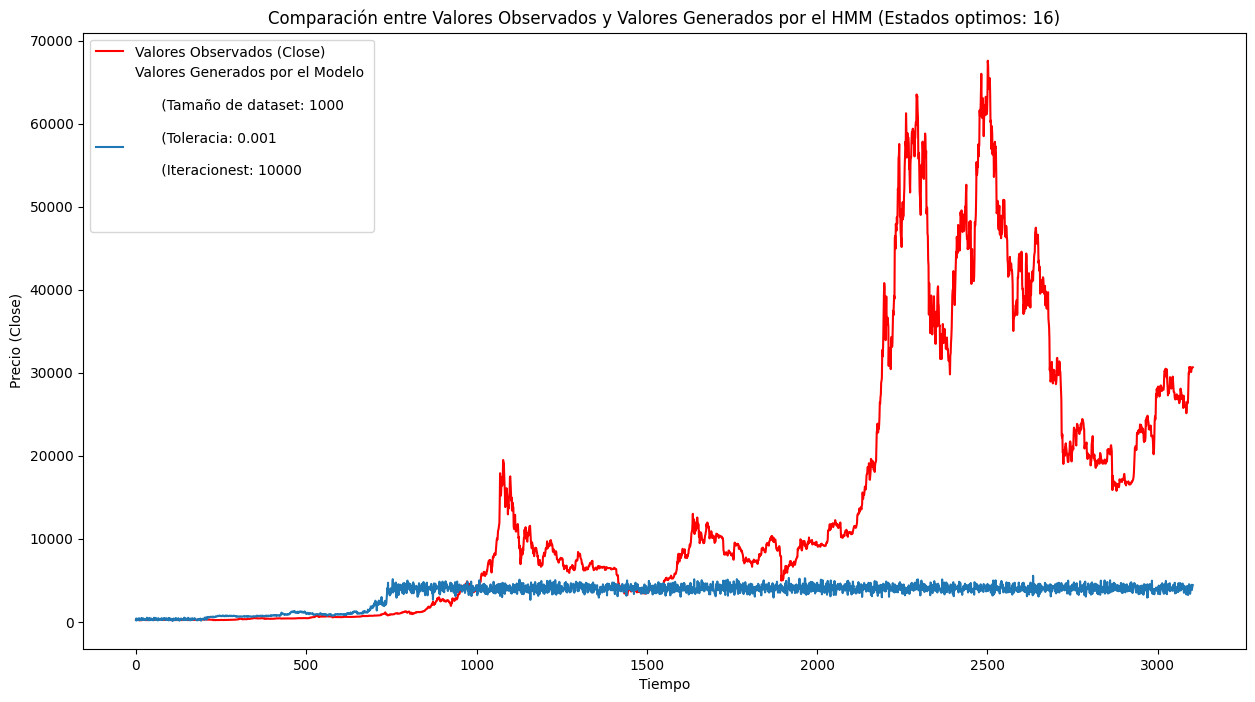

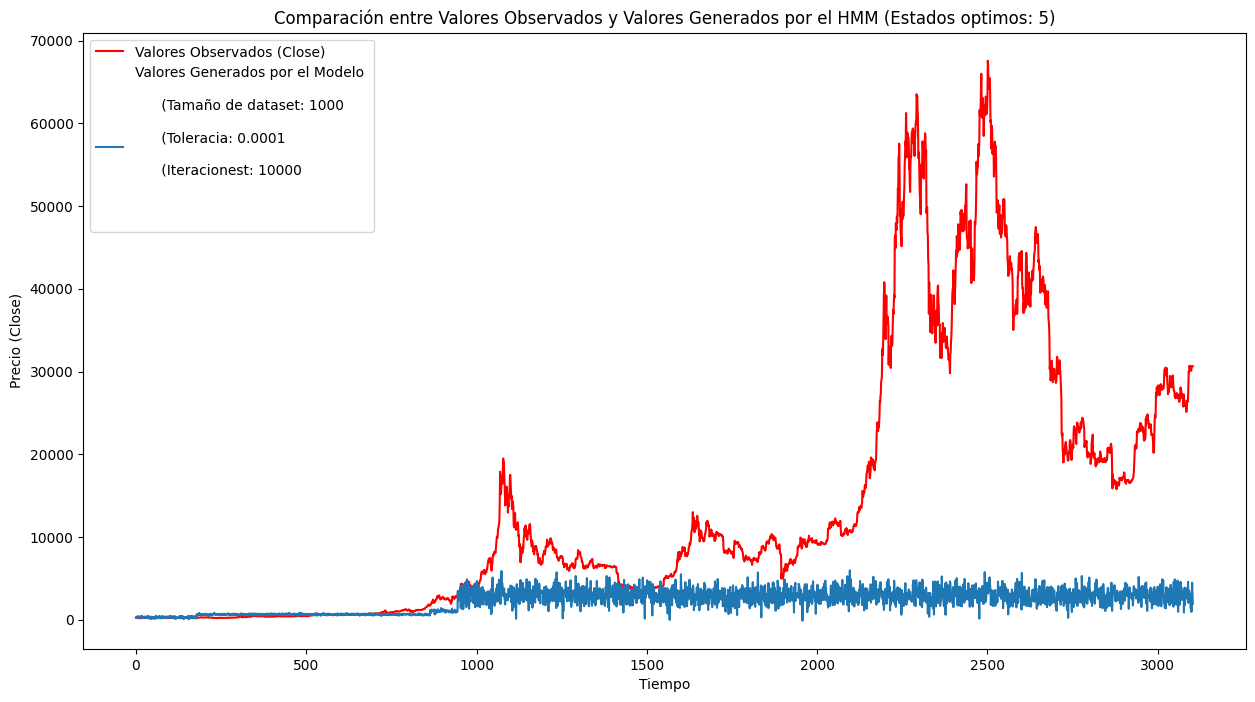

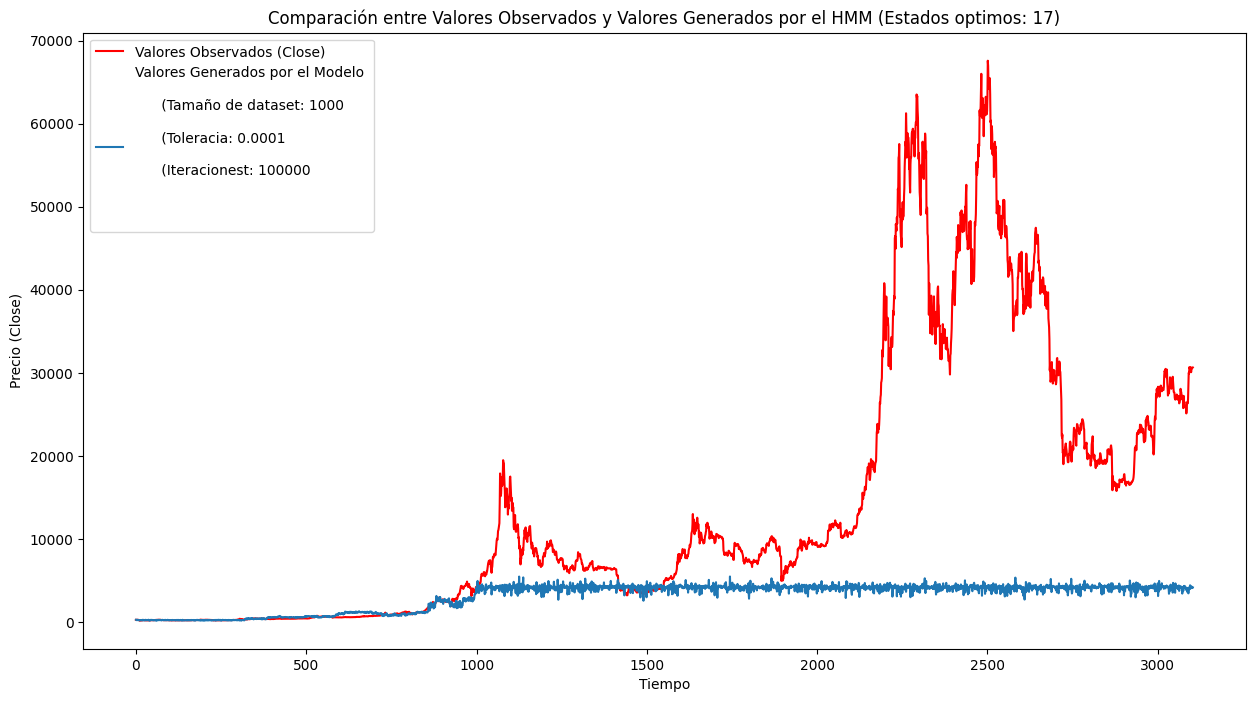

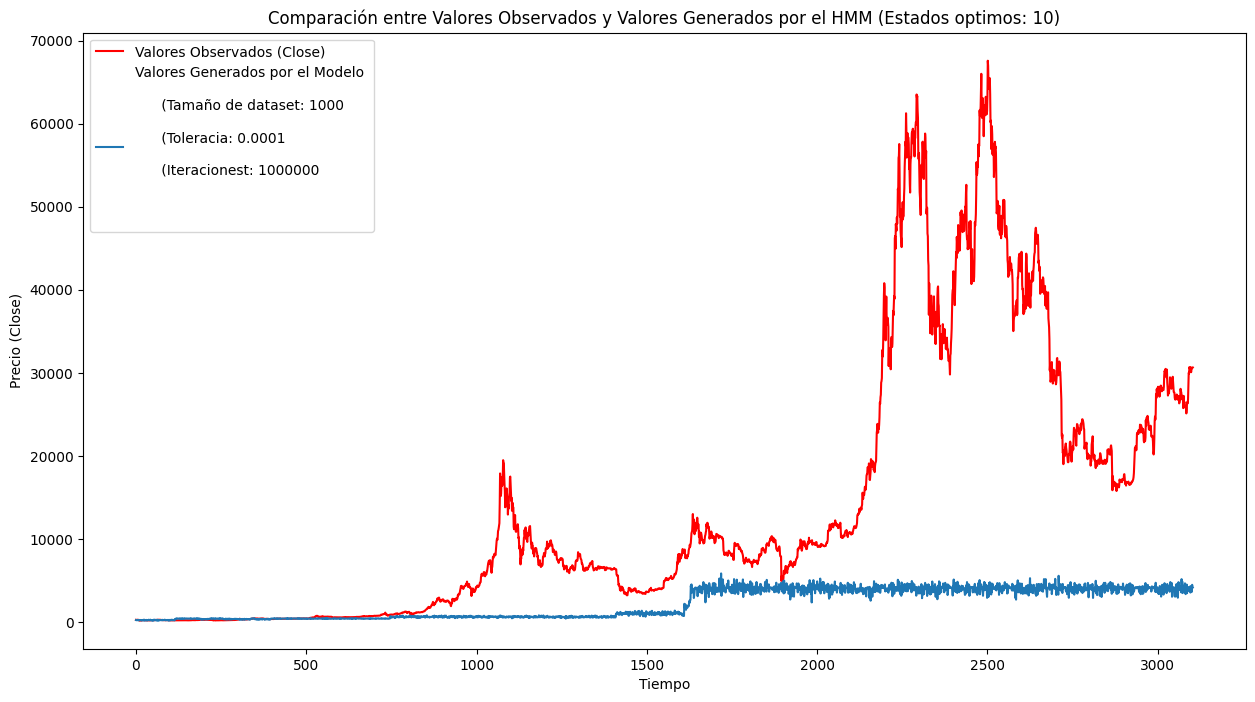

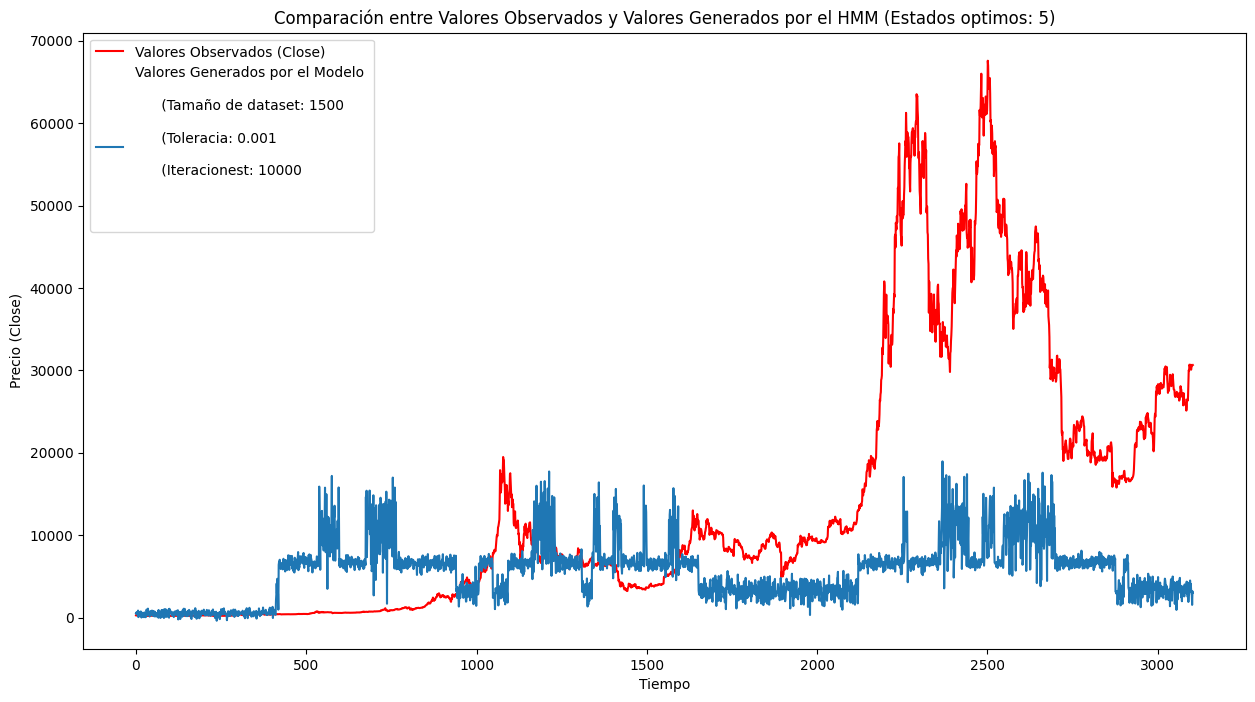

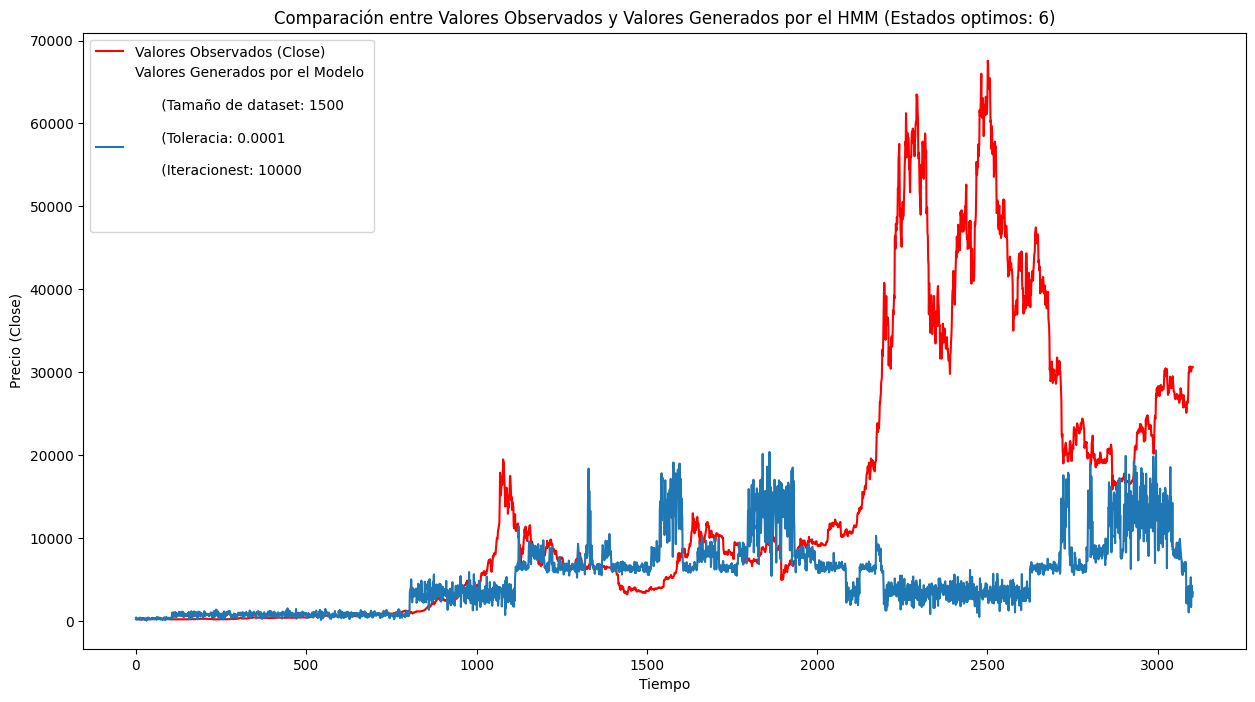

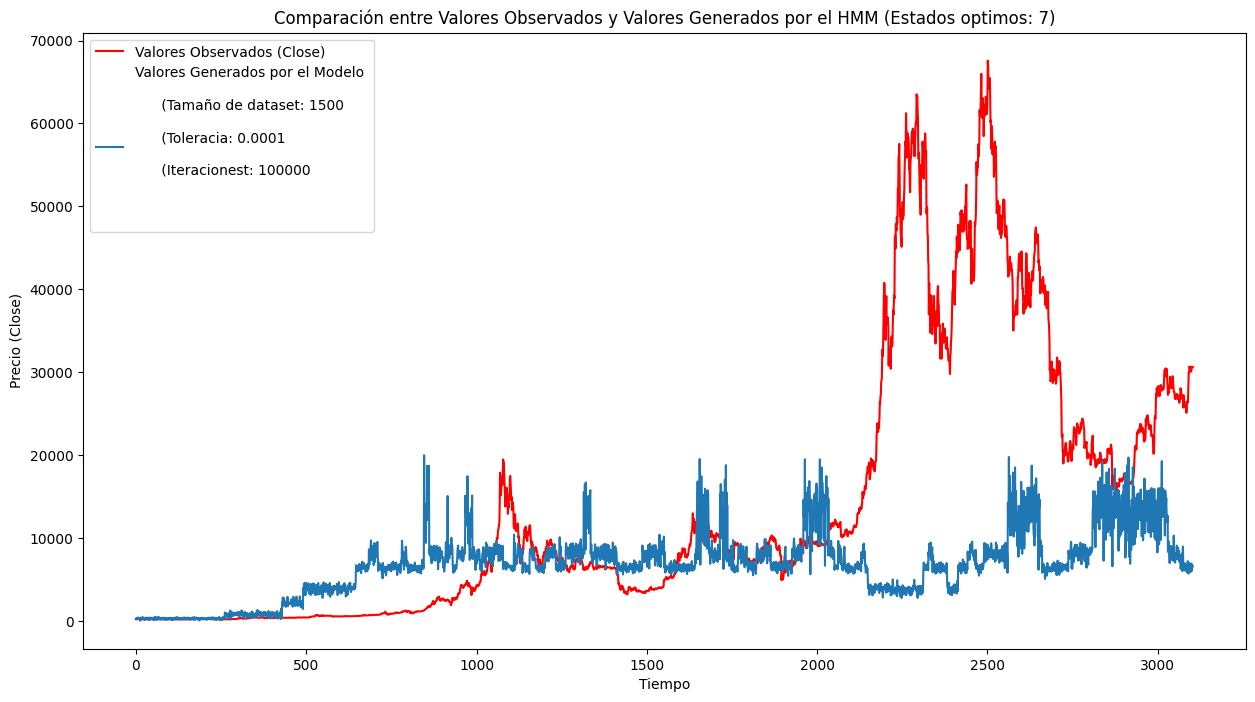

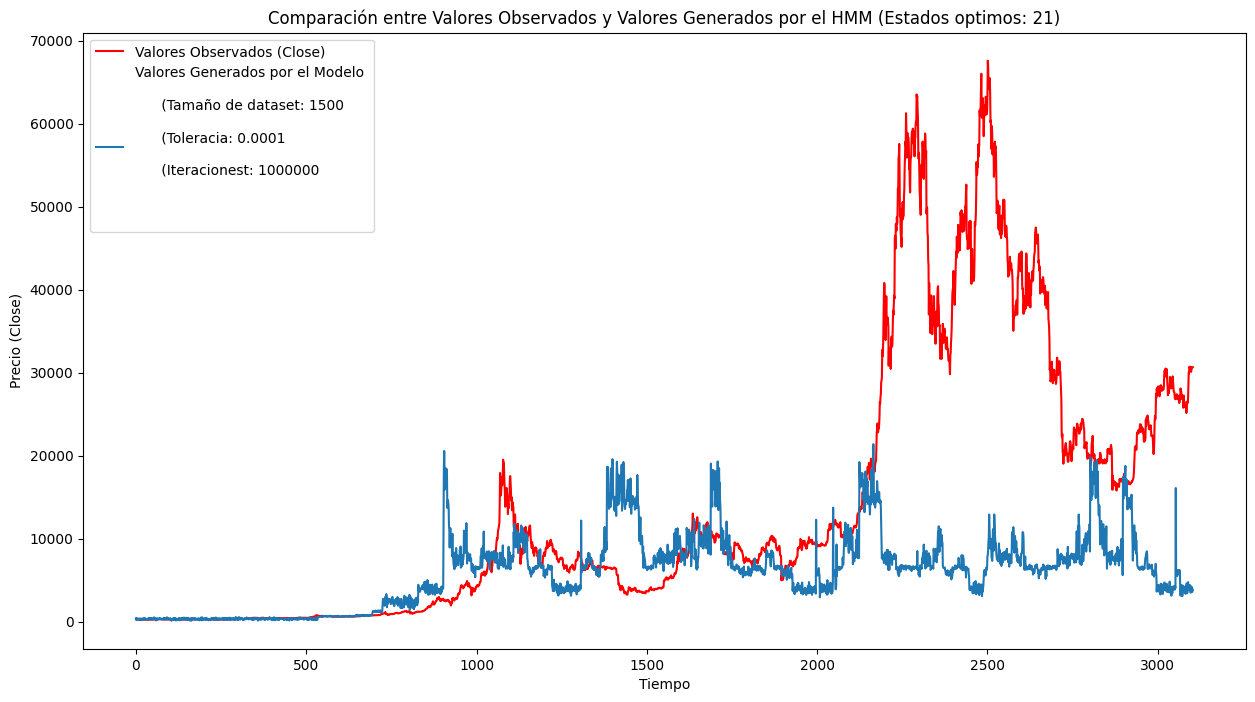

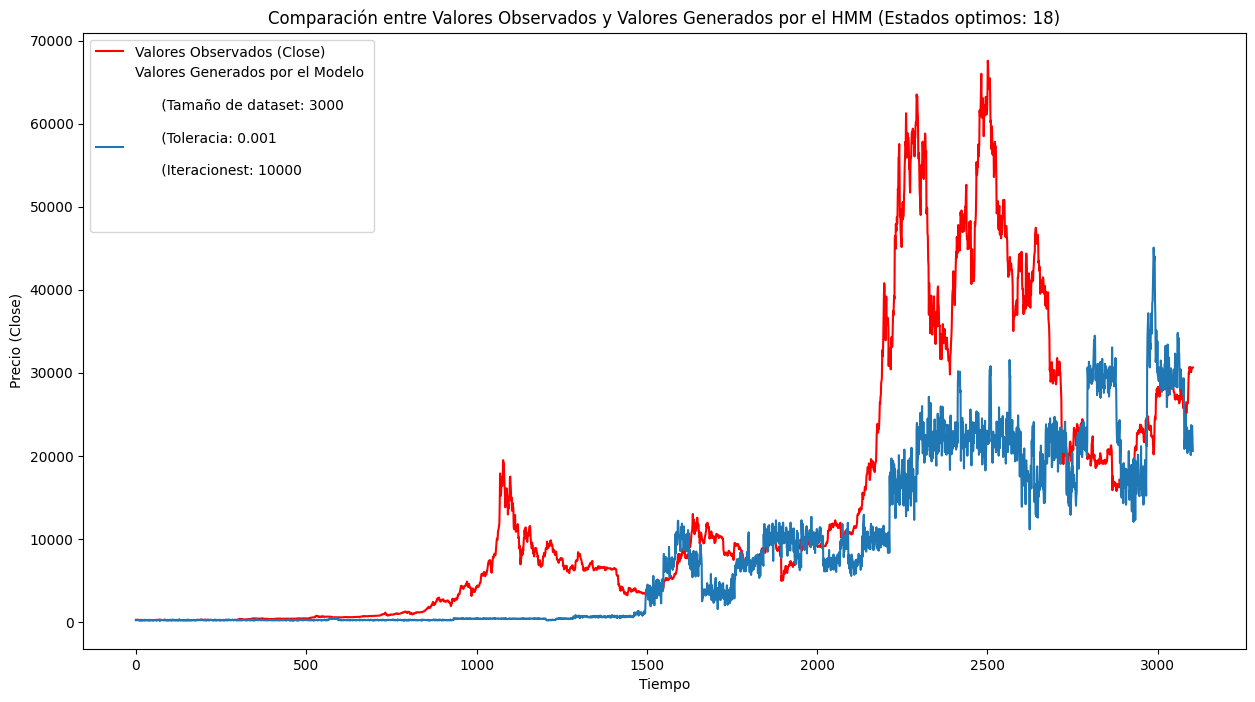

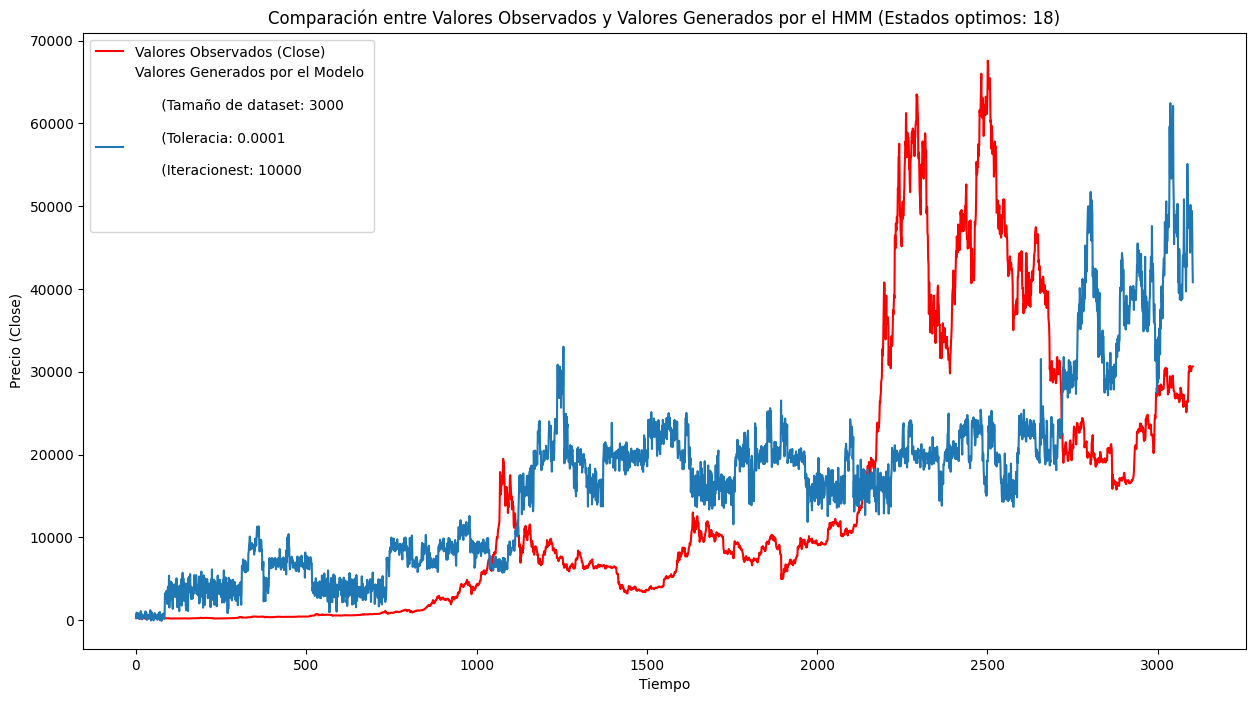

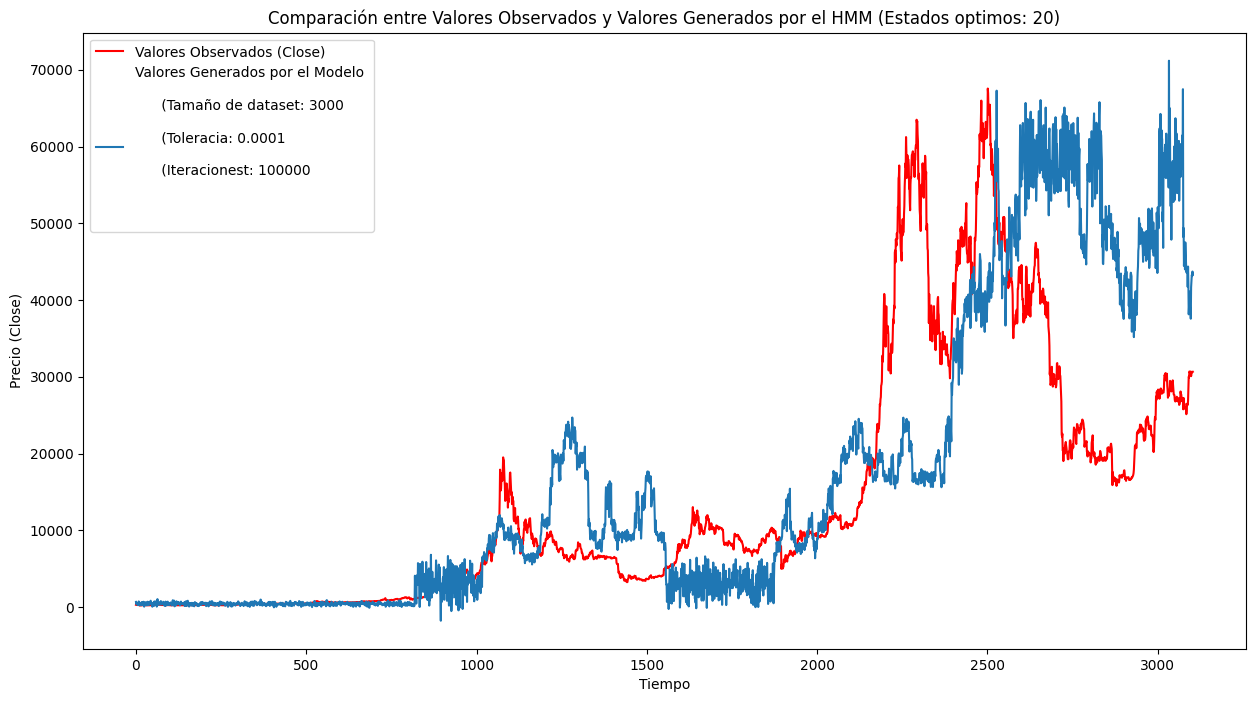

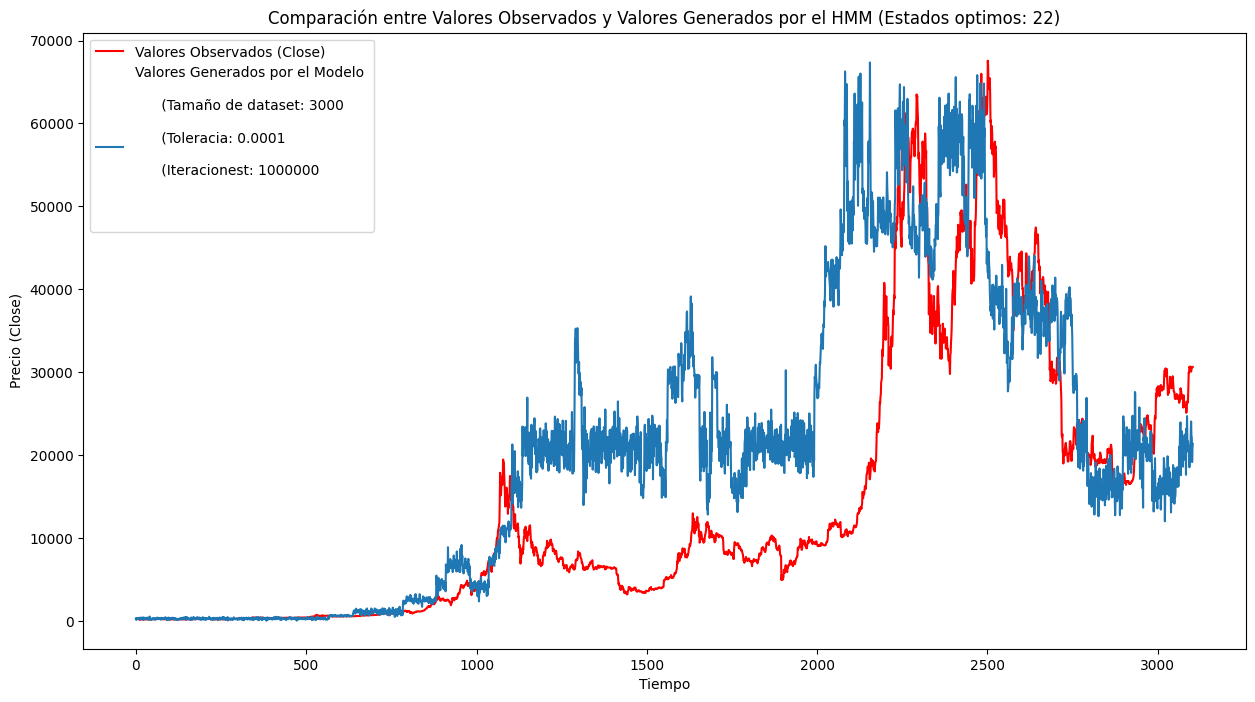

In [145]:
# Graficar comparación entre valores observados y valores generados por el modelo


# Gráfica de los valores generados por el modelo
hiper_params_index=0
for serie in generasted_data:
  plt.figure(figsize=(15, 8))

# Gráfica de los valores observados
  plt.plot(data[:, 0], label='Valores Observados (Close)', color='red')
  plt.plot(serie[:,0], label=f'''Valores Generados por el Modelo \n
      (Tamaño de dataset: {hiper_params_training[hiper_params_index]["size_data"]} \n
      (Toleracia: {hiper_params_training[hiper_params_index]["tol"]} \n
      (Iteracionest: {hiper_params_training[hiper_params_index]["iter"]} \n

  ''')

  # Configuración del gráfico
  plt.title(f'Comparación entre Valores Observados y Valores Generados por el HMM (Estados optimos: {hiper_params_training[hiper_params_index]["optimal_states"]})')
  plt.xlabel('Tiempo')
  plt.ylabel('Precio (Close)')
  plt.legend()
  plt.show()
  hiper_params_index+=1


Selección del mejor modelo basado en el criterio de información Bayesiano (BIC)

In [187]:
best_GHMM_model_by_BIC = max(hiper_params_training, key=lambda x: x["model"]["BIC"])["model"]["model"]
best_GHMM_model_by_insprection=hiper_params_training[-1]["model"]["model"]
observations, _ = best_GHMM_model_by_insprection.sample(5)
observations

array([[246.72060941, 388.12173674, 545.69502925, 372.22533735],
       [370.34516402, 303.96647595, 437.77894603, 395.68737403],
       [301.38465144, 535.04825376, 267.36664581, 252.82483756],
       [347.73564809, 327.34665136, 450.82092713, 452.34814338],
       [427.737108  , 282.91414499, 353.04626987, 315.43882982]])

#MODELO COMPARATIVO BASADO EN LSTM

##El objetivo de esta sección es implementar un modelo comparativo basado esn un red nreuronal de arquitetura LSTM, y comparar métricas relacionadas a los datos

In [211]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Escalar los datos para LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (20%) para HMM y LSTM
train_size = int(len(data) * 0.7)
train_data_lstm = scaled_data[:train_size]
test_data_lstm = scaled_data[train_size:]

# Crear el conjunto de datos para LSTM (usando ventanas de 60 pasos de tiempo)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Número de pasos de tiempo para el LSTM
X, y = create_dataset(train_data_lstm, time_step)
X_test, y_test = create_dataset(scaled_data, time_step)


# Redimensionar los datos para el LSTM
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Crear el modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(10, return_sequences=True, input_shape=(time_step, X.shape[2])))
lstm_model.add(Dropout(0.2))  # Añadir dropout del 20%
lstm_model.add(LSTM(10, return_sequences=False))
lstm_model.add(Dropout(0.2))  # Añadir dropout del 20%
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compilar el modelo LSTM
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo LSTM con el dataset entrenamiento
lstm_model.fit(X, y, batch_size=64, epochs=10, verbose=1)

# Hacer predicciones con LSTM
train_predict_lstm = lstm_model.predict(X_test)
train_predict_lstm = scaler.inverse_transform(np.concatenate((train_predict_lstm, np.zeros((train_predict_lstm.shape[0], 3))), axis=1))[:, 0]
y_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:, 0]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 8.7136e-04
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7674e-04
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 3.8357e-04
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.9518e-04
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.3381e-04
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.4101e-04
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.6365e-04
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 2.5050e-04
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.5279e-04
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.4510e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


LSTM MSE (Conjunto completo): 12130447.794013355
HMM MSE (Conjunto completo): 242693693.15161896
HMM2 MSE (Conjunto completo): 242693693.15161896


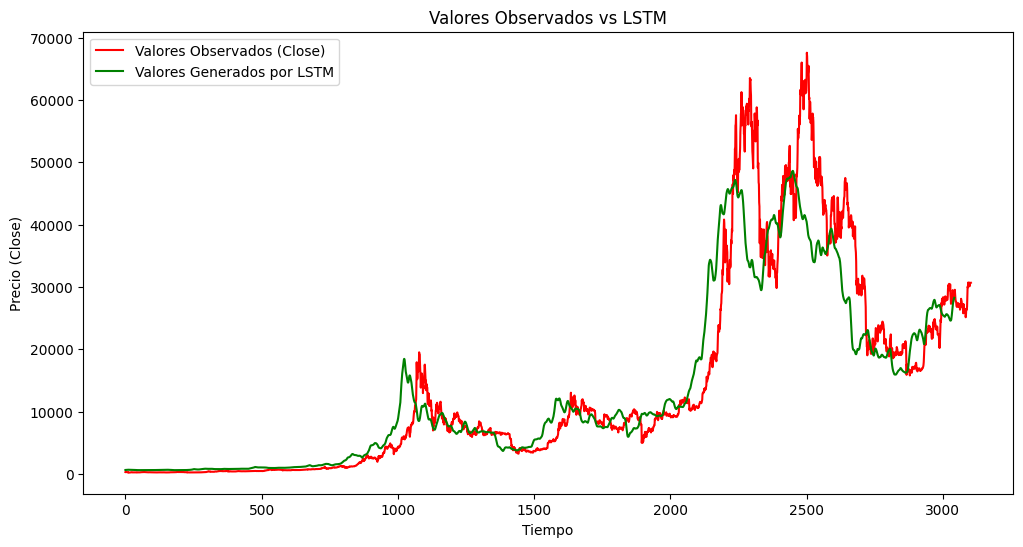

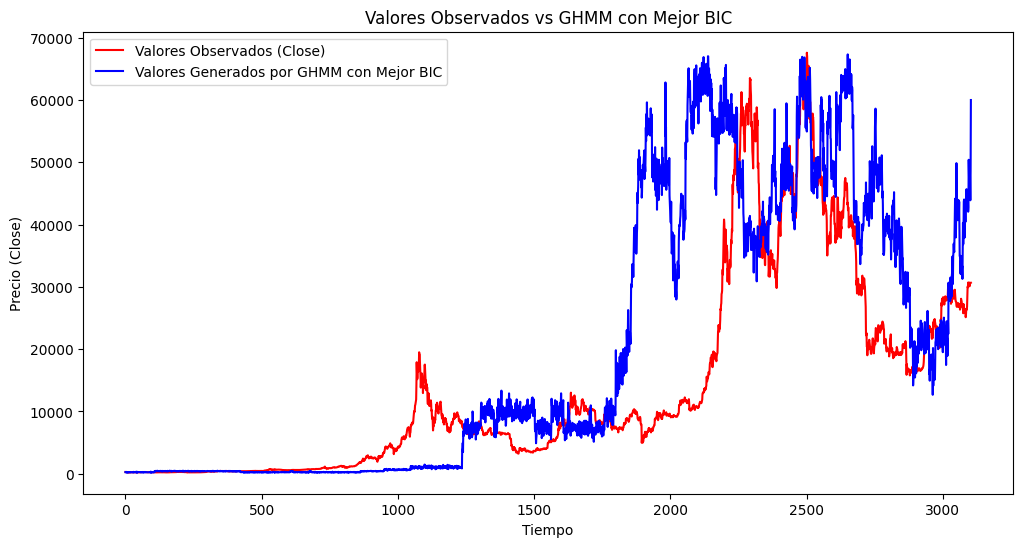

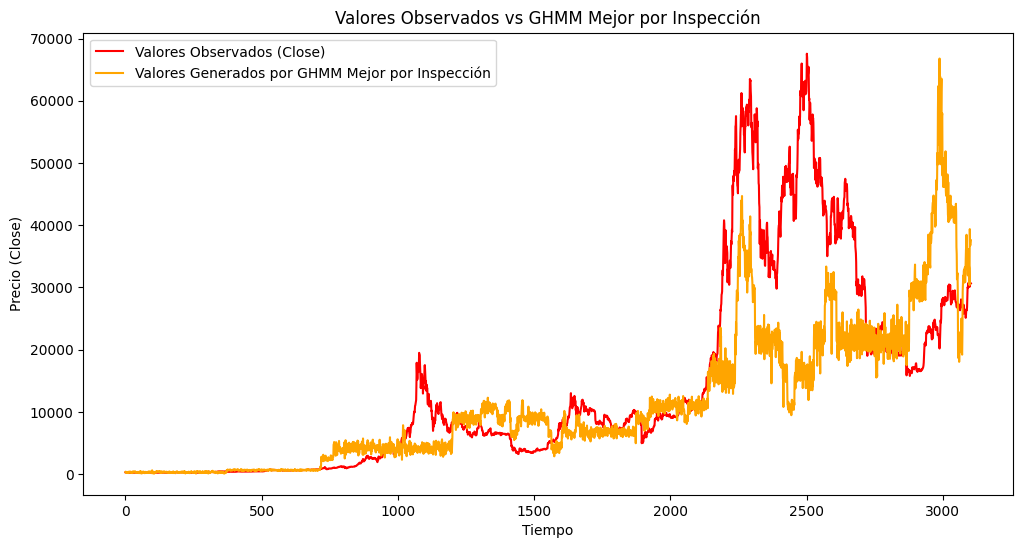

In [222]:
mse_lstm = mean_squared_error(y_original, train_predict_lstm)
print(f"LSTM MSE (Conjunto completo): {mse_lstm}")

hmm_predict, _ = best_GHMM_model_by_BIC.sample(len(data))
hmm_predict2, _ = best_GHMM_model_by_insprection.sample(len(data))
# Calcular el MSE para HMM en el conjunto completo (con los datos originales)
mse_hmm = mean_squared_error(data[:, 0], hmm_predict[:, 0])
print(f"HMM MSE (Conjunto completo): {mse_hmm}")
mse_hmm = mean_squared_error(data[:, 0], hmm_predict[:, 0])
print(f"HMM2 MSE (Conjunto completo): {mse_hmm}")

# Gráfica 1: Valores Observados vs Predicciones LSTM
plt.figure(figsize=(12, 6))
plt.plot(data[:, 0], label='Valores Observados (Close)', color='red')
plt.plot(train_predict_lstm, label='Valores Generados por LSTM', color='green')
plt.title('Valores Observados vs LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Precio (Close)')
plt.legend()
plt.show()

# Gráfica 2: Valores Observados vs Predicciones HMM (Mejor BIC)
plt.figure(figsize=(12, 6))
plt.plot(data[:, 0], label='Valores Observados (Close)', color='red')
plt.plot(hmm_predict[:, 0], label='Valores Generados por GHMM con Mejor BIC', color='blue')
plt.title('Valores Observados vs GHMM con Mejor BIC')
plt.xlabel('Tiempo')
plt.ylabel('Precio (Close)')
plt.legend()
plt.show()

# Gráfica 3: Valores Observados vs Predicciones HMM (Mejor por Inspección)
plt.figure(figsize=(12, 6))
plt.plot(data[:, 0], label='Valores Observados (Close)', color='red')
plt.plot(hmm_predict2[:, 0], label='Valores Generados por GHMM Mejor por Inspección', color='orange')
plt.title('Valores Observados vs GHMM Mejor por Inspección')
plt.xlabel('Tiempo')
plt.ylabel('Precio (Close)')
plt.legend()
plt.show()


#Validación de los modelos: Se cargan datos reales para validar el comportamiento de los modelos GHMM seleccionados.

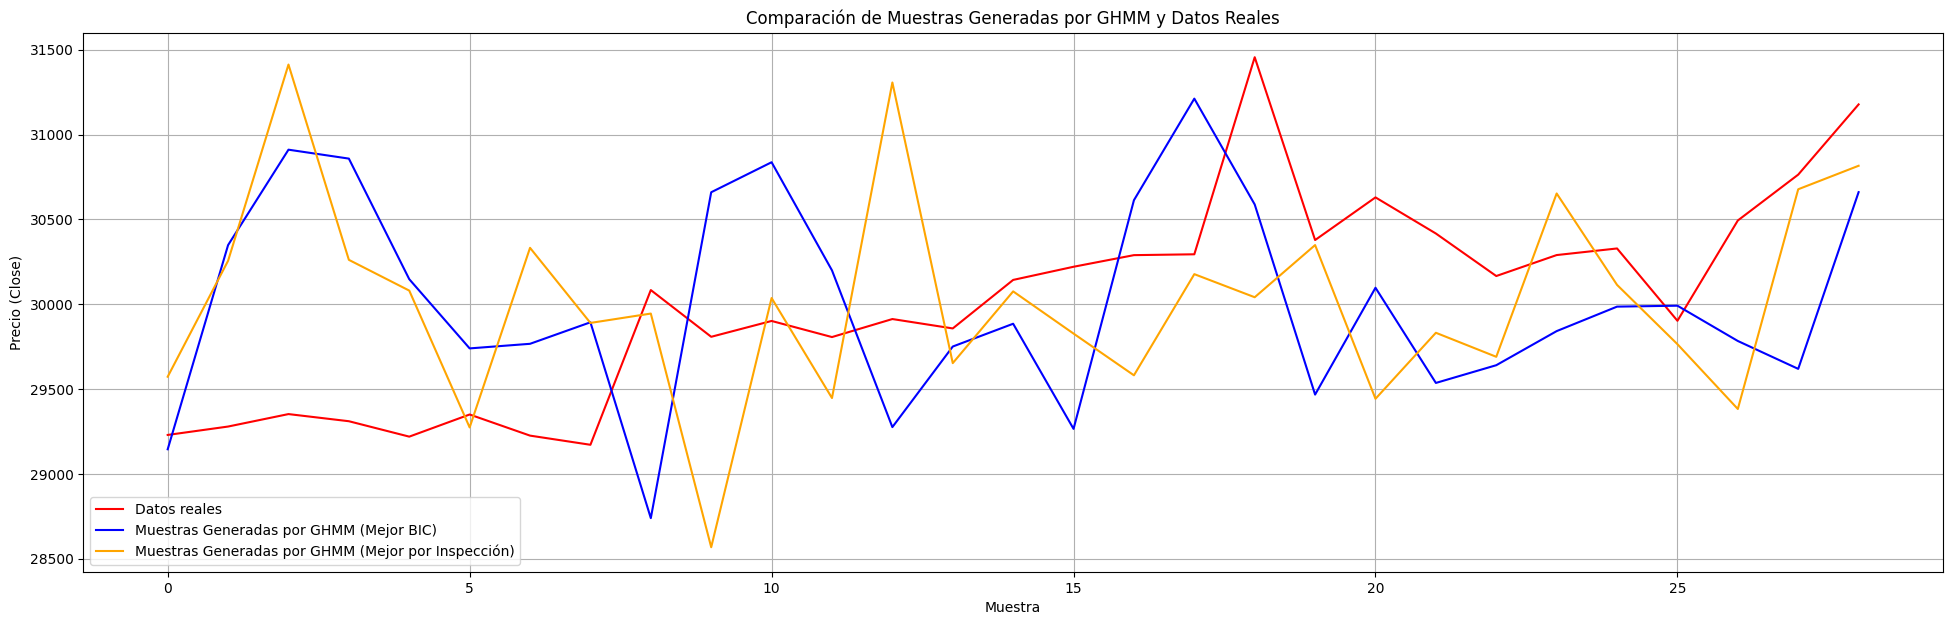

In [224]:
real_data = pd.read_csv('real_data.csv')
real_close = real_data['close'].values

n_samples = len(real_close)

gen1, _ = best_GHMM_model_by_BIC.sample(n_samples)
gen2, _ = best_GHMM_model_by_insprection.sample(n_samples)

gen1_values = gen1[:, 0]
gen2_values = gen2[:, 0]

mean_real = np.mean(real_close)
std_real = np.std(real_close)

gen1_rescaled = (gen1_values - np.mean(gen1_values)) / np.std(gen1_values) * std_real + mean_real
gen2_rescaled = (gen2_values - np.mean(gen2_values)) / np.std(gen2_values) * std_real + mean_real

plt.figure(figsize=(24, 7))
plt.plot(range(n_samples), real_close, label='Datos reales', color='red')
plt.plot(range(n_samples), gen1_rescaled, label='Muestras Generadas por GHMM (Mejor BIC)', color='blue')
plt.plot(range(n_samples), gen2_rescaled, label='Muestras Generadas por GHMM (Mejor por Inspección)', color='orange')

plt.title('Comparación de Muestras Generadas por GHMM y Datos Reales')
plt.xlabel('Muestra')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.show()